<a href="https://colab.research.google.com/github/revans011/classifier_accuracy/blob/main/two_classifiers_two_unlabeled_datasets_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifier accuracy using two unlabeled datasets
This notebook has a Bayesian model and MCMC code for the two-classifier, two-unlabeled-dataset model to determine the confusion matrix and assesses the accuracy of binary classifiers on unlabeled data.

#Definition
Two of the model parameters are the "prevalences" of the two datasets.  *If the data were labeled*, "prevalence" is the proportion of $1$'s in the dataset. However, the data aren't labeled, so prevalence is a model parameter instead of a known constant. Prevalence comes from this model's origins in diagnostic test assesment and unkown the prevalence of disease in a population of animals.

#The Data
The model uses the binary predictions of two different binary classifers (they can be supervised or unsupervised) from unlabeled datasets. So, there are two prediction lists, one for each classifier

\

**A simple example**: \

For dataset 1, the lists might be 


Classifier A: [1,0,1,1,0,1,1,0] \
Classifier B: [1,1,1,1,0,0,0,0] 



Next, it is a useful heuristic to arrange two predictions into a counts, in a 2x2 table. The first element is the count of (1,1)'s, the last element is the count of the (0,0)'s, the second element is the number of times classifer A is 1 and classifier B is 0 (i.e., (1,0)) and the third element is the number of times the classifer A is 0 and classifer B is 1 (i.e., (0,1)).



\begin{array}{cc|cl}
      &    &    \text{Classifier A}\\ 
      &    &     1&       0 \\ \hline
 \text{Classifer B}  &    1&  3&       2  \\
      &    0&    1&       2  \\
\end{array}
 
<br>

**We will use the list form, [3,2,1,2], in the code. It is not necessary to make a 2x2 table**.  


 <br>
For dataset 2, the arrays might be 

Classifier A: [1,0,1,1,0,1,0,0,0,1]  \
Classifier B: [1,1,1,1,0,0,0,0,0,0]  \\

For dataset 2, the list is [3,2,3,4].


For the code, we will use data in the form of [3,2,1,2] and [3,2,3,4], and also the lengths of the list, 8 and 12.


In this notebook, I use the data within the definition of the likelihood function. **It's a little hard to spot in the code, and I've commented where it happens.**


#The prior distribtions
The prior distributions for the sensitivities, specificities, and prevalences are all Beta distributions. Even with an identifiable model, like the one presented here, sensible priors help MCMC convergence. Branscum et al. (2005) developed the very useful Windows app "BetaBuster" to help elicit Beta  distribution parameters. Alternatively use this [website's](https://www.omnicalculator.com/statistics/beta-distribution) online calculator. The idea is to find Beta distribution parameters, $\alpha$ and $\beta$, that reflect resonable assumptions. 

For example, if a previouly trained supervised classifier is in the model, then its sensitivity and specificity were most likely assessed on a labeled dataset sometime previously and are good. Then it would be reasonable to pick Beta paramenters $\alpha$ and $\beta$ such that $Pr(x>0.5)=90\%$

#Assumptions
This model has two mild assumptions
1. The two classifiers are independent. In practice, that means that the classifiers should be different kinds of classifiers. For example, a classification tree and and KNN, rather than two classification trees with different numbers of leaves.
1. The datasets should have different prevalences. 

#References
1. Evans, R. (2022). Confusion Matrices and Accuracy Statistics for Binary Classifiers Using Unlabeled Data: The Diagnostic Test Approach. arXiv:2208.12664 \[stat.ML\]

1. Branscum, A. J., Gardner, I. A., and Johnson, W. O. (2005). Estimation of diagnostic-test sensitivity and specificity through Bayesian modeling. Preventive Veterinary Medicine, 68, 145-163.

1. We used the [emcee](https://arxiv.org/abs/1202.3665) ensemble sampler for the MCMC

1. This paper set up the underpinnings:  \
Hui, Sui L., and Walter, S.D. (1980). Estimating the error rates of diagnostic tests. Biometrics 167-171.



Copyright (c) <2022>, <Richard Evans>
All rights reserved.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd
!pip install emcee
from scipy.stats import beta
from scipy.stats import binom
import emcee
np.seterr(all="ignore") #supresses  "the invalid value encountered in double_scalars lnpdiff = f + nlp - state.log_prob[j]" warning--it doesn't affect the MCMC


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.1 MB/s 


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#The model specification

In [ ]:


#The prior distribution for the sensitivity, classifier A
def log_prior_seA(se):  
    a,b = 20,4
    if se<=0.0: 
      return -np.inf
    elif se>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(se,a,b))


#The prior distribution for the specificity, classifier A
def log_prior_spA(sp):  
    a,b = 20,4
    if sp<=0.0: 
      return -np.inf
    elif sp>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(sp,a,b))


#The prior distribution for the sensitivity, classifier B
def log_prior_seB(se):  
    a,b = 20,4
    if se<=0.0: 
      return -np.inf
    elif se>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(se,a,b))

#The prior distribution for the specificity, classifier B
def log_prior_spB(sp):  
    a,b = 20,4
    if sp<=0.0: 
      return -np.inf
    elif sp>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(sp,a,b))

#The prior distribution for the prevalence dataset 1
def log_prior_prev1(prev):  
    a,b = 4,20
    if prev<=0.0: 
      return -np.inf
    elif prev>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(prev,a,b))

#The prior distribution for the prevalence dataset 2
def log_prior_prev2(prev):  
    a,b = 20,4
    if prev<=0.0: 
      return -np.inf
    elif prev>=1.0: 
      return np.inf
    else: 
      return np.log(beta.pdf(prev,a,b))

#the likelihood for dataset 1
def log_multinomial1(seA,spA,seB,spB,prev1):

    k =[40,3,7,100]  #The data go here. The sum of the k's must sum to n
    n = sum(k)          

    p=[0,0,0,0]
    p[0] = prev1*seA*seB + (1-prev1)*(1-spA)*(1-spB)  #pos on both
    p[1] = prev1*seA*(1-seB) + (1-prev1)*(1-spA)*spB  #pos on CA, neg on CB
    p[2] = prev1*(1-seA)*seB + (1-prev1)*spA*(1-spB)  #neg on CA, pos on CB
    p[3] = prev1*(1-seA)*(1-seB) + (1-prev1)*spA*spB  #neg on both


    if any([x<=0.0 for x in p]): 
      return -np.inf
    elif any([x>=1.0 for x in p]): 
      return np.inf
    else: 
      return np.log(sp.multinomial.pmf(k, n=n, p=p))

#the likelihood for dataset 2
def log_multinomial2(seA,spA,seB,spB,prev2):

    k =[100,3,7,40]  #The data go here. The sum of the k's must sum to n
    n = sum(k)          

    p=[0,0,0,0]
    p[0] = prev2*seA*seB + (1-prev2)*(1-spA)*(1-spB)  #pos on both
    p[1] = prev2*seA*(1-seB) + (1-prev2)*(1-spA)*spB  #pos on CA, neg on CB
    p[2] = prev2*(1-seA)*seB + (1-prev2)*spA*(1-spB)  #neg on CA, pos on CB
    p[3] = prev2*(1-seA)*(1-seB) + (1-prev2)*spA*spB  #neg on both


    if any([x<=0.0 for x in p]): 
      return -np.inf
    elif any([x>=1.0 for x in p]): 
      return np.inf
    else: 
      return np.log(sp.multinomial.pmf(k, n=n, p=p))

#the log posterior distribtion
def log_post(theta):
    seA,spA,seB,spB,prev1, prev2 = theta
    sum_priors = log_prior_seA(seA) + log_prior_spA(spA) + \
                 log_prior_seB(seB) + log_prior_spB(spB)+ \
                 log_prior_prev1(prev1) +log_prior_prev2(prev2)

    lnprobval = log_multinomial1(seA,spA,seB,spB,prev1) + log_multinomial2(seA,spA,seB,spB,prev2) + sum_priors
    if not np.isfinite(sum_priors):      #this if statement is from the emcee example
        return -np.inf
    return(lnprobval)



#Running the ensemble sampler

In [ ]:
%%time

ndim, nwalkers = 6, 18 #There are 6 dimesions (two sensitivity, two specificity, and two prevalences) I often use nwalkers = 3 x ndim

# Starting positions for the walkers.
p0 = [0.5 +(1e-2 * np.random.rand(ndim)) for i in range(nwalkers)]

#make the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)

#Run the sampler
_ = sampler.run_mcmc(p0, nsteps=100000)


CPU times: user 24min 2s, sys: 9.07 s, total: 24min 11s
Wall time: 24min 5s


#Establishing convergence: Trace plots
There are many ways to verify that the Markov Chains are a representative sample from the posterior distribution. I used an overly simple approach here becuase the focus of this notebook is on the model specification, rather than a particular MCMC methodology.

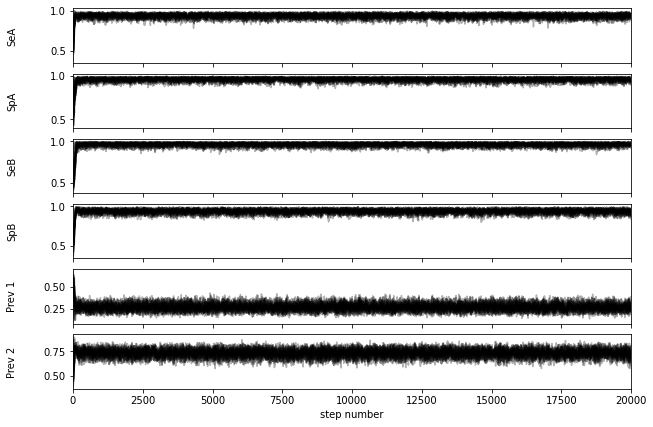

In [ ]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["SeA", "SpA","SeB", "SpB", "Prev 1", "Prev 2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Each plot above has *ndim* number of walkers

In [ ]:
#A snippet from the emcee website
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.502


In [ ]:
#A snippet from the emcee website
print(
    "Mean autocorrelation time (the number of steps needed to forget): {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time (the number of steps needed to forget): 90.663 steps


In [ ]:
#For each step in the chain, I take the median across the walkers. That gives a single chain for each of the six parameters

thin = 100 #thin the chains to reduce autocorrelation. Pick a number larger than the mean autocorrelation time

df_parameter_chains = pd.concat([pd.DataFrame(sampler.get_chain(thin=thin)[:,:,0]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin)[:,:,1]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin)[:,:,2]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin)[:,:,3]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin)[:,:,4]).median(axis=1),
                                pd.DataFrame(sampler.get_chain(thin=thin)[:,:,5]).median(axis=1)],axis=1)

df_parameter_chains.columns =['Sensitivity A', 'Specificity A', 'Sensitivity B', 'Specificity B', 'Prevalence 1','Prevalence 2']



#Remove the burn in 

In [ ]:
#Choose the burn in size after looking at the plots
burn_in = 100
df_parameter_chains.drop(index=df_parameter_chains.index[:burn_in], 
        axis=0, 
        inplace=True)

#Posterior summaries (point estimates) for classifier sensitivity, <br> specificity, and dataset prevalence
For example, for the classifier that produced the data for this analysis, we might use the medians and say the classifier's sensitivity is an appalling 0.499561


In [ ]:
#summary statistics from the estimated posterior distributions of the parameters
df_parameter_chains.describe().round(decimals=3)

,Sensitivity A,Specificity A,Sensitivity B,Specificity B,Prevalence 1,Prevalence 2
count,900.000,900.000,900.000,900.000,900.000,900.000
mean,0.936,0.959,0.959,0.936,0.267,0.733
std,0.006,0.005,0.005,0.007,0.010,0.010
min,0.917,0.942,0.944,0.913,0.232,0.697
25%,0.932,0.956,0.956,0.932,0.260,0.726
50%,0.936,0.959,0.959,0.936,0.267,0.734
75%,0.940,0.962,0.962,0.941,0.274,0.740
max,0.953,0.971,0.975,0.956,0.309,0.763


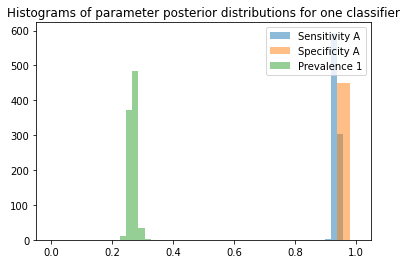

In [ ]:
#Some histograms
from matplotlib import pyplot

x = df_parameter_chains['Sensitivity A']
y = df_parameter_chains['Specificity A']
z = df_parameter_chains['Prevalence 1']

bins = np.linspace(0, 1, 50)

pyplot.hist(x, bins, alpha=0.5, label='Sensitivity A')
pyplot.hist(y, bins, alpha=0.5, label='Specificity A')
pyplot.hist(z, bins, alpha=0.5, label='Prevalence 1')
pyplot.legend(loc='upper right')
pyplot.title('Histograms of parameter posterior distributions for one classifier')
pyplot.show()

#Confusion Matrix
###Note: This matrix is for classifier A only. It is **not** a 2x2 table of classifier A and classifier B
Our primary classifier is classifier A. The numbers in the top row are the sensitivity and 1-sensitivity, and in the bottom row, 1-specificity and specificity. Simply multiply the matrix by a sample size and round the decimal if you prefer integers in the confusion matrix. 

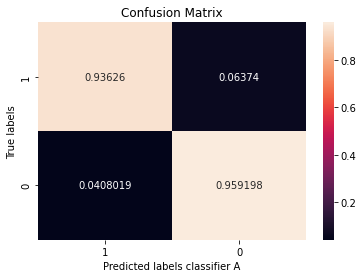

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


#make the elements of the confusion matrix
cm11 = df_parameter_chains['Sensitivity A'].median()
cm12 = 1-df_parameter_chains['Sensitivity A'].median()
cm21 = 1-df_parameter_chains['Specificity A'].median()
cm22 = df_parameter_chains['Specificity A'].median()


cm = np.array([[cm11,cm12],[cm21,cm22]])

#A snippet to plot a seaborn heatmap
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels classifier A');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);

#Accuracy summaries for classifier A
The real advantage of using the Bayesian approach is that it's easy to express uncertain about estimates. The table below uses the estimates of the posterior distributions (the Markov chain from the emcee sampler) to give summaries. For example, the standard deviations (std) of the accuracy statistics (e.g., F1) represents uncertainty about the mean. Likewise the 25th and 75th percentiles give uncertain about the median. 

In [ ]:
se_A = df_parameter_chains['Sensitivity A']                 #rename to simplify construction of the summary table
sp_A = df_parameter_chains['Specificity A']
prev_1 = df_parameter_chains['Prevalence 1']
ppv = (se_A * prev_1 /(se_A*prev_1 +((1-se_A)*(1-prev_1)))) #define the positive predictive value (ppv)


df_accuracy = pd.concat([se_A*prev_1 + (sp_A*(1-prev_1)),   #combine four accuacy statisitcs into a pandas dataframe
                      se_A,      
                      ppv,     
                      (2*ppv*se_A/(ppv+se_A))], axis=1)

df_accuracy.columns = ['Accuracy','Recall','PPV','F1']      #label the columns

df_accuracy.describe().round(decimals=3)

,Accuracy,Recall,PPV,F1
count,900.000,900.000,900.000,900.000
mean,0.953,0.936,0.842,0.887
std,0.004,0.006,0.015,0.011
min,0.939,0.917,0.786,0.847
25%,0.950,0.932,0.832,0.880
50%,0.953,0.936,0.842,0.887
75%,0.956,0.940,0.853,0.894
max,0.964,0.953,0.882,0.915


#Discussion
The model specification presented in this notebook allows the estimation of senstivity and specificity using unlabeled data. The model has been used successful in biostatistics for over 40 years. That said, althougth all the parameters in this model are estimable, the Markov chains may be highly correlated and caution is alway required running MCMC.